In [66]:
# Headers
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from copy import deepcopy
from skimage.feature import greycomatrix, greycoprops
import cv2  
from numpy.linalg import det
from skimage import util, exposure
from math import sqrt, ceil
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
### Métrica de tiempo | IRR
import time

In [67]:
# global variables
black_value = np.float64(-1408.5106382978724)
images_filename = 'tr_im.nii'
masks_filename = 'tr_mask.nii'

In [68]:
def get_vals(mask):
    vals = []
    x, y = mask.shape
    for i in range(x):
        for j in range(y):
            if mask[i,j] not in vals:
                vals.append(mask[i][j])

    vals.remove(0)
    return vals

In [69]:
def apply_mask(img, mask, class_id):
    heigh, width = img.shape
    tmp = deepcopy(img)
    lineal_array = np.array(0)
    for x in range(heigh):
        for y in range(width):
            # Set pixel as black color if is not inside this mask
            if mask[x,y] != np.float64(class_id):
                tmp[x,y] = black_value
            # Count pixels inside this mask
            else:
                lineal_array = np.append(lineal_array, tmp[x,y])
    # In tmp is saved the image with mask applied
    # In lineal_array is saved just the mask's pixels
    lineal_array = np.delete(lineal_array, 0)
    return tmp, lineal_to_matrix(lineal_array)

In [70]:
def calculate_media_lineal_arr(array):
    length = array.shape[0]
    media = np.float64(0)
    for x in range(length):
        media += array[x]
    media = media/length
    return media

In [71]:
def lineal_to_matrix(lineal_array):
    sqrt_ = ceil(sqrt(lineal_array.shape[0]))
    media = calculate_media_lineal_arr(lineal_array)
    missing_values = sqrt_**2 - lineal_array.shape[0]
    # Complete square matrix
    for x in range(missing_values):
        lineal_array = np.append(lineal_array, media)
    
    return lineal_array.reshape([sqrt_, sqrt_])

In [72]:
def show_slice_mask(slicei, mask):
    """ Function to display images and mask """
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(slicei.T,  cmap="gray", origin="lower")
    ax[0].set_title('Image')
    ax[1].imshow(mask.T, cmap="gray", origin="lower")
    ax[1].set_title('Mask')
    plt.show()

In [73]:
def glcm_properties(image):
    distancias = [1,2]
    #0 -> Oeste a este, #-np.pi/2 -> Sur a norte
    angulos = [0, -np.pi/2]

    # Calculate properties for just one superpixel using the
    # respective mask  
    glcm = greycomatrix(image, 
                        distances = distancias, 
                        angles = angulos,
                        symmetric=True, 
                        normed=True)
    resultadosEnergy = greycoprops(glcm, 'energy')
    resultadosHomogeneity = greycoprops(glcm, 'homogeneity')
    resultadosContrast = greycoprops(glcm, 'contrast')
    
    # Returning determinat for every matrix in order to work just with
    # 1-D arrays
    return [resultadosEnergy, resultadosHomogeneity, resultadosContrast]

In [74]:
def glcmAlternative(superpixels):
    distancias = [1,2]
    #0 -> Oeste a este, #-np.pi/2 -> Sur a norte
    angulos = [0, -np.pi/2]
    
   
    glcm = greycomatrix(superpixels, distances=distancias, angles = angulos, symmetric=True, normed=True)
    filt_glcm = glcm[1:, 1:, :, :]
    
    contraste = greycoprops(filt_glcm, prop='contrast')
    energia = greycoprops(filt_glcm, prop='energy')
    correlacion =  greycoprops(filt_glcm, prop='correlation')
    
    return [contraste, energia, correlacion]

In [75]:
def valueMask(value):
    if value == 1.0:
        return 'Vidrio esmerilado'
    if value == 2.0:
        return 'Consolidación'
    else:
        return 'Derrame pleural'

In [76]:
def getROI(img, segments):
    auxiliar = [] 
    for (i, segVal) in enumerate(np.unique(segments)): #Accediendo a cada superpixel
        # construct a mask for the segment
        mask = np.zeros(img.shape[:2], dtype = "uint8")
        mask[segments == segVal] = 255
        mask = cv2.bitwise_and(img, img, mask = mask)
        auxiliar.append(mask) #Se agrega cada una de las mascarar
    
    #print("Función getROI, len(auxiliar) = ", len(auxiliar))
    return auxiliar

In [77]:
#funcion para segmentar superpíxeles
def SLIC(img, k):
    image = img_as_float(img)

    segments = slic(image, k, sigma = 5)
    # show the output of SLIC
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")
    plt.show()

#Para cada máscara, segmentamos en superpixeles
def getSuperPixels(tmp, number):
    #aux = np.asarray(cv2.normalize(tmp, 0, 255, cv2.NORM_MINMAX), dtype=np.double)
    aux = np.asarray(cv2.normalize(tmp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F),dtype=np.double)
    segments_slic = slic(aux, n_segments = number, compactness=0.1, sigma=0, enforce_connectivity=True, slic_zero=False)
    #print(f"Segmentos del algoritmo SLIC: {len(np.unique(segments_slic))}")
    
    ### Commented | Despliega imagen de superpixeles | IRR | 5-junio-2020
    # show the output of SLIC
    fig = plt.figure("Superpixels")
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(mark_boundaries(aux, segments_slic))
    plt.axis("off")
    plt.show()
    
    superpixels = np.asarray(getROI(aux, segments_slic)) #Lista de superpixeles

    res = []
    for i in range(len(superpixels)): #Iteramos sobre el número de superpixeles
        prueba = np.asarray(cv2.normalize(superpixels[i], 0, 255, cv2.NORM_MINMAX), dtype=int)
        valuePixel = np.unique(prueba)
        if (len(valuePixel) > 1):
            res.append(prueba)
    
    return res
    

In [83]:
def main():
    ### Lista que returna la info GLCM |IRR ###
    info = []
    train = []
    to_show = 3
    imgs = nib.load(images_filename).get_fdata()
    masks = nib.load(masks_filename).get_fdata()

    for x in range(25, 25+to_show):
        print("\nImage no ", x)
        classes = get_vals(masks[:,:,x])
        show_slice_mask(imgs[:,:,x], masks[:,:,x])
        for j in classes:
            tmp, matrix_mask = apply_mask(imgs[:,:,x], masks[:,:,x], j)
            ### Commented | IRR | Se agregó valueMask | 5-junio-2020 ###
            print("\nclass ", valueMask(j))
            #show_slice_mask(tmp, masks[:,:,x])
            show_slice_mask(tmp, matrix_mask)
            print(glcm_properties(matrix_mask.astype(np.uint8)))
            

            ### Superpixeles de interés | IRR | 5-junio-2020###
            superpixels = getSuperPixels(tmp, 50)
            print("SP reducidos = ", len(superpixels))
            
            ### GLCM de cada superpixel | IRR | 5-junio-2020###
            for k in range(len(superpixels)):
                info.append(glcmAlternative(superpixels[k].astype(np.uint8)))
            
            test = np.array(info)
        ### Guarda info de GLCM | IRR | 6-junio-2020 ###
        train.append([np.mean(test[:,0]), np.mean(test[:,1]), np.mean(test[:,1])])
        
            #create_matrix(tmp)
        #print(get_prop(imgs[:,:,x].astype(np.uint8), masks[:,:,x].astype(np.uint8)))
        #get_every_mask(imgs[:,:,x], masks[:,:,x])
    return np.asarray(train)


Image no  25


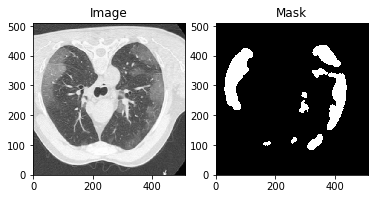


class  Vidrio esmerilado


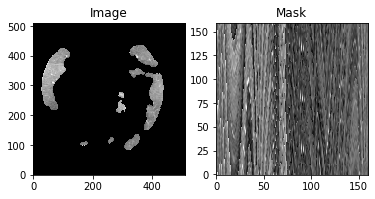

[array([[0.00795847, 0.00595827],
       [0.00679977, 0.00593684]]), array([[0.05140663, 0.01397761],
       [0.02981182, 0.01230585]]), array([[ 4560.19732704, 10017.42036164],
       [ 6778.47432753, 10405.93496835]])]


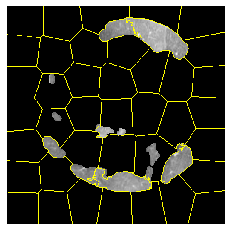

SP reducidos =  21

Image no  26


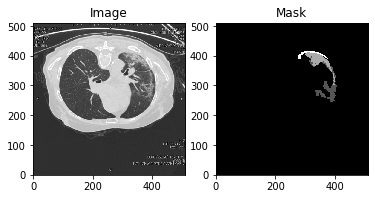


class  Derrame pleural


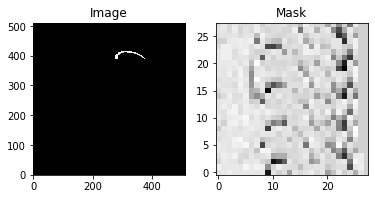

[array([[0.08211719, 0.05724626],
       [0.07955183, 0.04779154]]), array([[0.11239955, 0.09041826],
       [0.11321408, 0.04731954]]), array([[16414.3968254 , 16968.39814815],
       [17080.67445055, 17292.94505495]])]


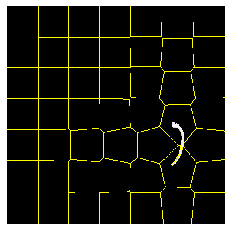

SP reducidos =  1

class  Consolidación


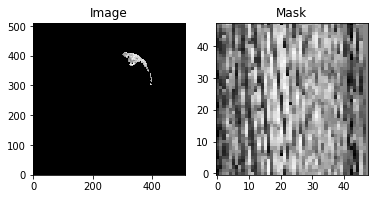

[array([[0.0315978 , 0.01832181],
       [0.03039823, 0.01790239]]), array([[0.05148818, 0.01988923],
       [0.04498262, 0.013601  ]]), array([[ 9490.8962766 , 10695.1498227 ],
       [10598.50634058, 10645.39402174]])]


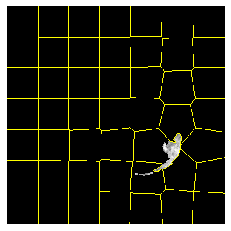

SP reducidos =  2

class  Vidrio esmerilado


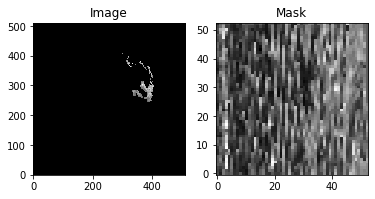

[array([[0.0247081 , 0.01764933],
       [0.02162126, 0.0178503 ]]), array([[0.05392107, 0.01839977],
       [0.03283184, 0.01543907]]), array([[ 9185.29535559, 11740.49637155],
       [11354.16056234, 11767.28079911]])]


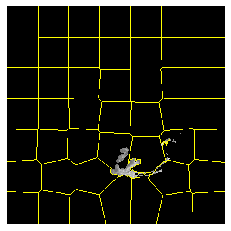

SP reducidos =  5

Image no  27


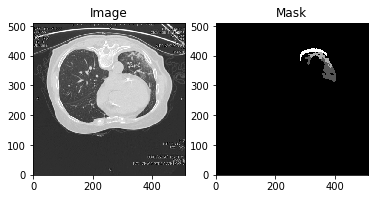


class  Derrame pleural


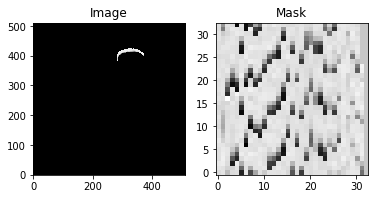

[array([[0.07019084, 0.04868382],
       [0.06310098, 0.0491099 ]]), array([[0.11821719, 0.06027719],
       [0.08094126, 0.04301846]]), array([[16347.14299242, 20045.89867424],
       [20376.01857283, 20704.59139785]])]


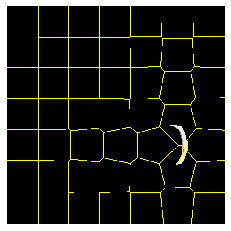

SP reducidos =  2

class  Vidrio esmerilado


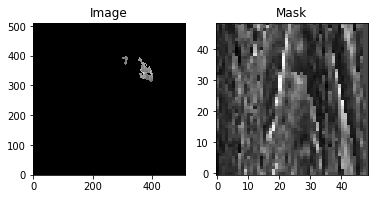

[array([[0.03928972, 0.02315323],
       [0.03641985, 0.0212167 ]]), array([[0.09147375, 0.03510773],
       [0.05186471, 0.02467606]]), array([[ 6663.22066327,  9624.50382653],
       [ 8325.47980894, 10663.88276162]])]


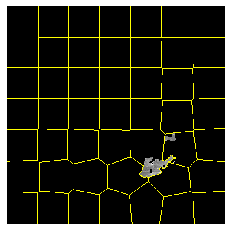

SP reducidos =  2

class  Consolidación


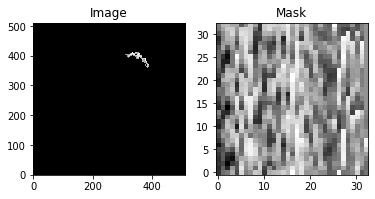

[array([[0.03053151, 0.02356985],
       [0.0294231 , 0.02417256]]), array([[0.04154641, 0.01188668],
       [0.03243551, 0.00931041]]), array([[10094.19412879, 10677.97159091],
       [10489.86803519, 10544.12609971]])]


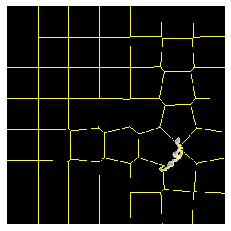

SP reducidos =  1


In [84]:
start = time.time()
infoTrain = main()
end = time.time()

In [82]:
print("Tiempo de entrenamiento: " +str(end - start))
print(infoTrain.shape)

Tiempo de entrenamiento: 46.679256439208984
(3, 3)
